In [1]:
from data.fetch_data import *
from strategies.alphas import *
from utils.ga_utils import *
import warnings
from utils.optimizer import *
from utils.data_utils import * 

warnings.filterwarnings("ignore")

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
stock_data = fetch_stock_data("LT.NS",'2022-08-01','2023-08-08')

[*********************100%%**********************]  1 of 1 completed


In [7]:
def evaluate_strategy(data,alpha_func,*args):
    data["alpha"] = alpha_func(data,*args[:-2])
    data["alpha"] = normalize_alphas(data["alpha"])
    threshold = args[-2]
    stop_loss_percentage =args[-1]
    
    data = data.dropna()

    position = 0  # 0 for no position, 1 for long position
    profit = 0
    total_trades = 0
    winning_trades = 0
    stricly_winning_trades = 0
    allocated_funds = 100000
    no_of_shares = 0
    stop_loss_price = 0
    returns = []

    for i in range(1,len(data)):
        try:

            if position == 0:
                if data['alpha'][i] > threshold: 
                
                    position = 1  # Buy (enter long position)
                    entry_price = data['Close'][i]
                    stop_loss_price = entry_price - (entry_price * 0.01 * stop_loss_percentage)
                    # print(f"Entry: {entry_price} on {data.index[i]} Stop Loss: {stop_loss_price}")
                    total_trades += 1
                    no_of_shares = allocated_funds//entry_price
                    

                    
            elif position == 1 :
                
                if data['Close'][i] > entry_price:  # Adjust stop loss only when the price goes up
                    stop_loss_price = max(stop_loss_price, data['Close'][i] - (data['Close'][i] * 0.01 * stop_loss_percentage))
                    
                if data['Low'][i] < stop_loss_price:
                    position = 0  # Sell due to stop loss
                    exit_price = data['Open'][i] if stop_loss_price > data['Open'][i] else stop_loss_price
                    trade_profit = (exit_price - entry_price) * no_of_shares  # Calculate profit/loss
                    profit=trade_profit
                    allocated_funds += profit
                    no_of_shares =0
                    return_on_trade = (exit_price -entry_price) * 100/entry_price
                    returns.append(return_on_trade)
                    # print(f"Exit: {exit_price} on {data.index[i]} exited on stop loss Allocated Funds {allocated_funds}")
                    # print(f"Profit: {profit}")
                    
                    # mask = (results_data['Symbol'] == symbol) & (results_data['Exit_Date'].isnull())
                    # results_data.loc[mask, 'Exit_Date'] = data.index[i]
                    # results_data.loc[mask, 'Exit_Price'] = exit_price
           
                    if(exit_price>= entry_price):
                        winning_trades += 1
                    if(exit_price> entry_price):
                        stricly_winning_trades += 1
                # elif data['MACD_E'][i] < data['Signal_E'][i]:
                #     position = 0  # Sell due to exit condition
                #     exit_price = data['Close'][i]
                #     trade_profit = (exit_price - entry_price) * no_of_shares  # Calculate profit/loss
                #     profit=trade_profit#                     
                #     # print(f"Exit: {exit_price} on {data.index[i]} exited on stop loss Allocated Funds {allocated_funds}")
                #     # print(f"Profit: {profit}")

                #     allocated_funds += profit
                    
                    
                #     # mask = (results_data['Symbol'] == symbol) & (results_data['Exit_Date'].isnull())
                #     # results_data.loc[mask, 'Exit_Date'] = data.index[i]
                #     # results_data.loc[mask, 'Exit_Price'] = exit_price

                #     no_of_shares =0
                #     if(exit_price>= entry_price):
                #         winning_trades += 1
                #     if(exit_price> entry_price):
                #         stricly_winning_trades += 1
            
        except Exception as ex:
            print("Something caused the error",ex)
            break
        win_rate = winning_trades/total_trades if total_trades != 0 else 0

            # Calculate metrics
        metrics = {
            "Profit": profit,
            "Total Trades": total_trades,
            "Winning Trades": winning_trades,
            "Strictly Winning Trades": stricly_winning_trades,
            "Win Rate": win_rate,
            "Allocated Funds": allocated_funds,
            "Sharpe Ratio": calculate_sortino_ratio(pd.Series(returns))
        }

    return metrics
    


In [9]:
run_ga_optimization(stock_data,generate_individual,alpha8,evaluate_strategy)

[123643.34958390739, 125190.10158425228, 125269.1557543653]
[125190.10158425228, 125269.1557543653, 125277.52987258224]
[125269.1557543653, 125277.52987258224, 125277.52987258224]
[125277.52987258224, 125277.52987258224, 125277.52987258224]
Saturation condition met, breaking the loop

Best Strategy Metrics (Generation Generation 4):

Best Individual Parameters: [9, 9, 0, -0.9666318953795755]
Profit: 51.70458984375
Total Trades: 116
Winning Trades: 89
Strictly Winning Trades: 85
Win Rate: 0.7672413793103449
Allocated Funds: 125277.52987258224
Sharpe Ratio: 0.9148177124895163


In [14]:
import importlib
tickers = []
alpha_function_names = ["alpha"+str(x) for x in range(1,2)]
alpha_functions = {}

for alpha_name in alpha_function_names:
    try:
        module = importlib.import_module("strategies.alphas")
        alpha_function = getattr(module, alpha_name)
        alpha_functions[alpha_name] = alpha_function

        best_metrics, best_individual = run_ga_optimization(stock_data, generate_individual, alpha_function, evaluate_strategy)

        results_dict["BPCL.NS"] = {
        "alpha_name": alpha_func.__name__,
        "best_metrics": best_metrics,
        "best_individual": best_individual
    }
        
    except AttributeError:
        print(f"Failed to import {alpha_name}")





KeyboardInterrupt: 

In [5]:
data= yf.download("LT.NS", start = '2023-08-01',end='2024-02-01')

[*********************100%%**********************]  1 of 1 completed


In [14]:
evaluate_strategy(data,alpha11,17, 5, 0, -0.9838885246829239)

{'Profit': 477.75299072265625,
 'Total Trades': 51,
 'Winning Trades': 39,
 'Strictly Winning Trades': 36,
 'Win Rate': 0.7647058823529411,
 'Allocated Funds': 107857.98748779297,
 'Sharpe Ratio': 0.8349406596569037}

<AxesSubplot:>

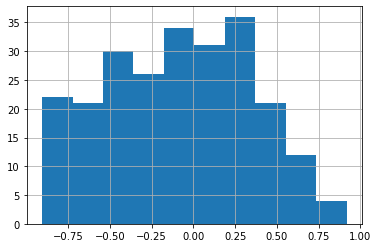

In [ ]:
signal.hist()

In [45]:
pd.Series([1,2,3])<0

0    False
1    False
2    False
dtype: bool

In [9]:
data = stock_data

<AxesSubplot:>

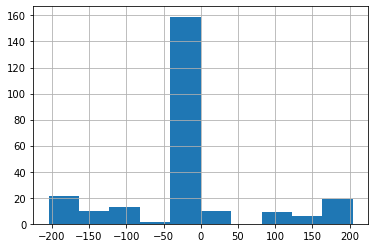

In [43]:
pd.Series(signal).hist()

In [33]:
a =generate_individual(alpha14)

In [34]:
list(a.values())

[4, 9, 0, 1]

In [41]:
def example_function(param1, *args, param2="default", **kwargs):
    print("param1:", param1)
    print("param2:", param2)
    print("Additional positional arguments:", *args[:-2])
    print("Additional keyword arguments:", kwargs)

In [42]:
example_function(1,2,3,4,5,5,6,7)

param1: 1
param2: default
Additional positional arguments: 2 3 4 5 5
Additional keyword arguments: {}
